In [ ]:
!uv pip install medmnist

In [2]:
from medmnist import INFO

# Information about OCTMNIST dataset
info = INFO["octmnist"]

print("Dataset type: ", info["task"])
print("Dataset labels: ", info["label"])
print("Number of image channels: ", info["n_channels"])
print("Number of training samples: ", info["n_samples"]["train"])
print("Number of validation samples: ", info["n_samples"]["val"])
print("Number of test samples: ", info["n_samples"]["test"])

Dataset type:  multi-class
Dataset labels:  {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
Number of image channels:  1
Number of training samples:  97477
Number of validation samples:  10832
Number of test samples:  1000


In [3]:
import torch

# Use GPU if available
# NOTE: use CPU if running Federated learning in Google Colab

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [4]:
from torchvision import transforms
from medmnist import OCTMNIST

# Define transformations
transform = transforms.ToTensor()

# Download datasets in size 64 x 64
train_dataset = OCTMNIST(split='train', transform=transform, download=True, size=64)
val_dataset = OCTMNIST(split='val', transform=transform, download=True, size=64)
test_dataset = OCTMNIST(split='test', transform=transform, download=True, size=64)

100%|██████████| 312M/312M [00:14<00:00, 22.2MB/s]


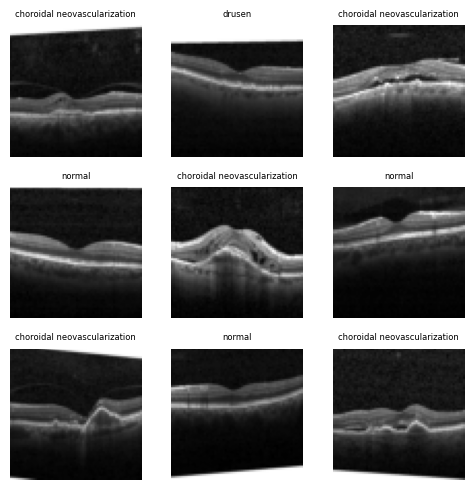

In [5]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the label map
label_map = {
    0: 'choroidal neovascularization',
    1: 'diabetic macular edema',
    2: 'drusen',
    3: 'normal'
}

# Get a batch from the data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
images, labels = next(iter(train_loader))

# Plot in 3 x 3 grid
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(5, 5))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i][0], cmap='gray')
    ax.set_title(label_map[int(labels[i].item())], fontsize=6)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from torch.utils.data import Subset

# Create subdatasets
def create_sub_datasets(full_dataset):
    targets = torch.tensor([label.item() for _, label in full_dataset])
    mask_A = (targets == 0) | (targets == 2) | (targets == 3)
    mask_B = (targets == 0) | (targets == 1) | (targets == 3)
    mask_C = (targets == 1) | (targets == 2) | (targets == 3)

    indices_A = mask_A.nonzero(as_tuple=True)[0]
    indices_B = mask_B.nonzero(as_tuple=True)[0]
    indices_C = mask_C.nonzero(as_tuple=True)[0]

    dataset_A = Subset(train_dataset, indices_A)  # Contains: CNV, DRUSEN, NORMAL (excludes DME)
    dataset_B = Subset(train_dataset, indices_B)  # Contains: CNV, DME, NORMAL (excludes DRUSEN)
    dataset_C = Subset(train_dataset, indices_C)  # Contains: DME, DRUSEN, NORMAL (excludes CNV)

    return [dataset_A, dataset_B, dataset_C]

dataset_A, dataset_B, dataset_C = create_sub_datasets(train_dataset)

In [8]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# ResNet-18
def get_resnet_model(num_classes=4):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Modify first conv layer to accept 1 channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Replace the final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)

In [14]:
import torch.optim as optim
from tqdm import tqdm

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()

        running_correct, running_total = 0, 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

        for images, labels in loop:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=running_correct / running_total)

        train_acc = running_correct / running_total

        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}]  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [16]:
# Function to train on a data subset
def train_on_subset(subset_dataset, val_loader, epochs=10):
    loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)
    model = get_resnet_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, loader, val_loader, epochs)

    return model

In [17]:
# Evaluation function when training using a data subset
def evaluate_on_test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze().to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum([p == t for p, t in zip(all_preds, all_labels)]) / len(all_labels)

    return acc, all_preds, all_labels

In [ ]:
# Train models on sub-datasets
val_loader = DataLoader(val_dataset, batch_size=64)

model_A = train_on_subset(dataset_A, val_loader)
model_B = train_on_subset(dataset_B, val_loader)
model_C = train_on_subset(dataset_C, val_loader)

In [ ]:
# Evaluate on full test set
test_loader = DataLoader(test_dataset, batch_size=64)

acc_A, preds_A, labels_A = evaluate_on_test(model_A, test_loader)
acc_B, preds_B, labels_B = evaluate_on_test(model_B, test_loader)
acc_C, preds_C, labels_C = evaluate_on_test(model_C, test_loader)

# Report accuracy
print(f"Test Accuracy | Model trained on dataset excluding DME: {acc_A:.4f}")
print(f"Test Accuracy | Model trained on dataset excluding DRUSEN: {acc_B:.4f}")
print(f"Test Accuracy | Model trained on dataset excluding CNV: {acc_C:.4f}")

Test Accuracy | Model excluding DME:     0.6070
Test Accuracy | Model excluding DRUSEN: 0.7200
Test Accuracy | Model excluding CNV:     0.6980


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CNV", "DME", "DRUSEN", "NORMAL"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

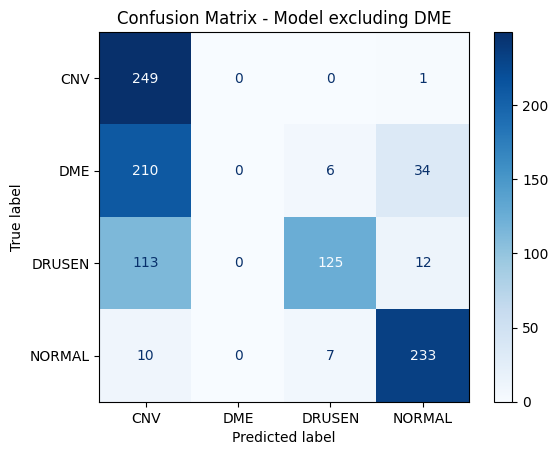

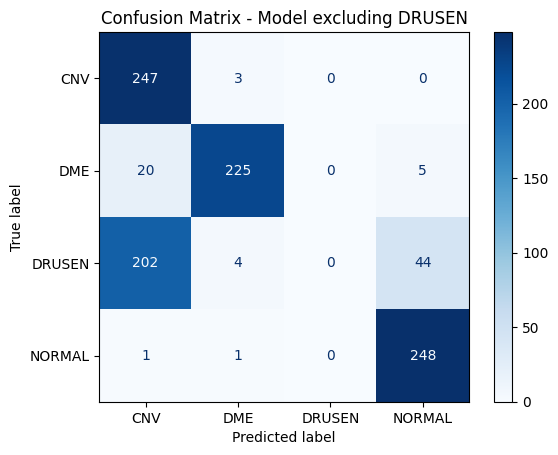

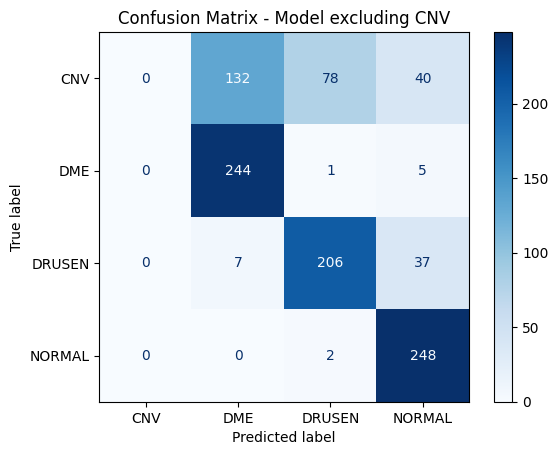

In [ ]:
# Plot confusion matrices
plot_confusion_matrix(labels_A, preds_A, "Confusion Matrix - Model excluding DME")
plot_confusion_matrix(labels_B, preds_B, "Confusion Matrix - Model excluding DRUSEN")
plot_confusion_matrix(labels_C, preds_C, "Confusion Matrix - Model excluding CNV")

## Federated Learning Using FlowerAI

In [ ]:
!uv pip install "flwr[simulation]"

In [20]:
# Get client model's updated weights after training
def get_weights(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [21]:
from collections import OrderedDict

# Updates the weights of the client model before training
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)

    state_dict = OrderedDict({
        k: torch.tensor(v) for k, v in params_dict
    })

    net.load_state_dict(state_dict, strict=True)

In [26]:
from flwr.client import NumPyClient
from typing import Dict
from flwr.common import NDArrays, Scalar

# Flower Client
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, valset, testset):
        self.net = net
        self.trainset = trainset
        self.valset = valset
        self.testset = testset

    # Local training
    def fit(self, parameters, config):
        set_weights(self.net, parameters)

        # Data loaders
        train_loader = DataLoader(self.trainset, batch_size=64, shuffle=True)
        val_loader = DataLoader(self.valset, batch_size=64)

        # Loss & Optimiser
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=0.001)

        train_model(
            self.net,
            criterion,
            optimizer,
            train_loader,
            val_loader,
            epochs= 1,
        )

        return get_weights(self.net), len(self.trainset), {}

    # Local evaluation
    def evaluate(self, parameters, config):
        set_weights(self.net, parameters)
        loss, acc = evaluate_model(
            self.net, DataLoader(self.testset, batch_size=64)
        )

        return loss, len(self.testset), {"accuracy": acc}

In [29]:
from flwr.client import Client, ClientApp
from flwr.common import Context

train_sets = [dataset_A, dataset_B, dataset_C]

#  Function to set up a Client
def client_fn(context: Context) -> Client:
    cid = int(context.node_config["partition-id"])

    trainset = train_sets[cid]

    return FlowerClient(
        get_resnet_model(),
        trainset,
        val_dataset,
        test_dataset,
    ).to_client()

client = ClientApp(client_fn)

In [30]:
def filter_by_classes(dataset, class_list):
    indices = [i for i, (_, label) in enumerate(dataset) if label.item() in class_list]
    return Subset(dataset, indices)

# Includes: CNV, DRUSEN, NORMAL - excludes: DME
testset_no_dme = filter_by_classes(test_dataset, [0, 2, 3])

# Includes: CNV, DME, NORMAL - excludes: DRUSEN
testset_no_drusen = filter_by_classes(test_dataset, [0, 1, 3])

# Includes: DME, DRUSEN, NORMAL - excludes: CNV
testset_no_cnv = filter_by_classes(test_dataset, [1, 2, 3])

In [31]:
# Evaluate global model
def evaluate(server_round, parameters, config, num_rounds=5):
    net = get_resnet_model()
    set_weights(net, parameters)
    batch_size = 64

    acc_tot = evaluate_model(net, DataLoader(test_dataset, batch_size=batch_size))
    acc_A = evaluate_model(net, DataLoader(testset_no_dme, batch_size=batch_size))
    acc_B = evaluate_model(net, DataLoader(testset_no_drusen, batch_size=batch_size))
    acc_C = evaluate_model(net, DataLoader(testset_no_cnv, batch_size=batch_size))

    print(f"[Round {server_round}] Global  accuracy: {acc_tot:.4f}")
    print(f"[Round {server_round}] (CNV,DRUSEN,NORMAL) accuracy: {acc_A:.4f}")
    print(f"[Round {server_round}] (CNV,DME,NORMAL)    accuracy: {acc_B:.4f}")
    print(f"[Round {server_round}] (DME,DRUSEN,NORMAL) accuracy: {acc_C:.4f}")

    # Plot confusion matrix at final round
    if server_round == num_rounds:
        acc_final, preds_final, labels_final = evaluate_on_test(net, DataLoader(test_dataset, batch_size=64))
        plot_confusion_matrix(labels_final, preds_final, "Final Global Confusion Matrix")

In [32]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg

net = get_resnet_model()
params = ndarrays_to_parameters(get_weights(net))

# Function to set up the global server
def server_fn(context: Context, num_rounds = 5):
    # Federated Averaging strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )

    config=ServerConfig(num_rounds)

    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

server = ServerApp(server_fn=server_fn)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [ ]:
from flwr.simulation import run_simulation
from logging import ERROR

# To keep the log outputs clean
backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": False}}

# Run training simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
    backend_config=backend_setup,
)

Counter({3: 46026, 0: 33484, 1: 10213, 2: 7754})


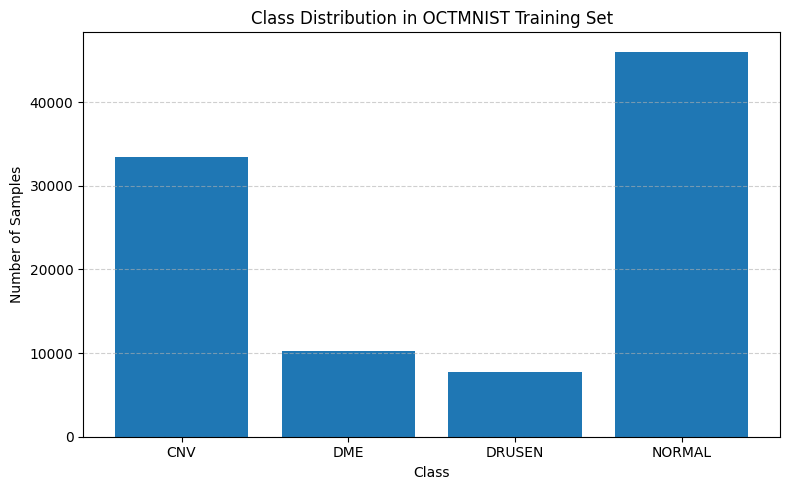

In [34]:
# Check class imbalance

import matplotlib.pyplot as plt
from collections import Counter

# Count class occurrences
labels = [label.item() for _, label in train_dataset]
class_counts = Counter(labels)
print(class_counts)

# Prepare data for plotting
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
counts = [class_counts[i] for i in range(4)]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts)
plt.title("Class Distribution in OCTMNIST Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()